预训练网络是一个保存好的，之前在大型数据集上训练好的网络。

本例使用 VGG16 ，对于 ImageNet ，它是一种简单而又广泛使用的卷积神经网络架构。

使用预训练网络有两种方法：特征提取和微调模型。

## 特征提取

特征提取是使用之前网络学到的表示来从新样本中提取出有趣的特征。然后将这些特征输入一个新的分类器，从头开始训练。

对于图像分类的卷积神经网络包含两部分：首先是一系列池化层和卷积层，最后是一个密集连接分类器。

第一部分叫做模型的卷积基。对于卷积神经网络而言，特征提取就是取出之前训练好的网络的卷积基，在上面运行新数据，然后在输出上面训练一个新的分类器。

本例，使用在 ImageNet 上训练的 VGG16 网络的卷积基从猫狗图像中提取有趣的特征，然后在这些特征上训练一个猫狗分类器。

### 将 VGG 卷积基实例化

In [1]:
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
conv_base = VGG16(weights='imagenet',#指定模型初始化的权重检查点
                  include_top=False,#指定模型最后是否包含全连接分类器，VGG自带1000个类别分类，本例只需要猫狗两类，所以无需包含
                  input_shape=(150, 150, 3)#输入张量的形状，如果不传入此参数，网络能处理任意形状的输入
                 )

Instructions for updating:
Colocations handled automatically by placer.


VGG16 卷积基的详细架构：

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

最后的特征图形状为 (4, 4, 512)。我们将在这个特征上添加一个密集连接分类器。有两种方法：

（1）在数据集上运行卷积基，将输出保存成硬盘中的 Numpy 数组，然后用这个数据作为输入，输入到独立的全连接分类器中。速度快，计算代价低。对于输入图像只需运行一次卷积基，但无法使用数据增强。

（2）在顶部添加 Dense 层来扩展已有模型（即 conv_base），并在输入数据上端到段地运行整个模型，可以使用数据增强，计算代价高。

### 不使用数据增强的快速特征提取

首先，运行 ImageDataGenerator 实例，将图像及其标签提取为 Numpy 数组。调用 conv_base 模型的 predict 方法来从这些图像中提取特征。

#### 使用预训练的卷积基提取特征

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [5]:
base_dir = '/home/cqc/文档/git/DeepLearning_with_Keras/datasets/dogs-vs-cats-small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i=0
    for inputs_batch, label_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = label_batch
        i+=1
        if i * batch_size >= sample_count:
            break   #读取完所有图像后终止生成器
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


/home/cqc/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


目前，提取的特征形状为 (samples, 4, 4, 512)。我们需要将其输入到密集连接分类器中，所以首先必须将其形状展平为 (samples, 8192)。

In [6]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

#### 定义并训练密集连接分类器

In [7]:
from keras import models
from keras import layers
from keras import optimizers

In [8]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 502us/step - loss: 3.7651 - acc: 0.6725 - val_loss: 1.0336 - val_acc: 0.8790
Epoch 2/30
2000/2000 [==============================] - 1s 327us/step - loss: 1.9198 - acc: 0.8255 - val_loss: 0.9210 - val_acc: 0.9090
Epoch 3/30
2000/2000 [==============================] - 1s 327us/step - loss: 1.4416 - acc: 0.8730 - val_loss: 0.8025 - val_acc: 0.9200
Epoch 4/30
2000/2000 [==============================] - 1s 331us/step - loss: 1.1070 - acc: 0.9025 - val_loss: 0.8223 - val_acc: 0.9230
Epoch 5/30
2000/2000 [==============================] - 1s 323us/step - loss: 0.9700 - acc: 0.9125 - val_loss: 0.7578 - val_acc: 0.9300
Epoch 6/30
2000/2000 [==============================] - 1s 325us/step - loss: 0.8367 - acc: 0.9200 - val_loss

#### 绘制结果

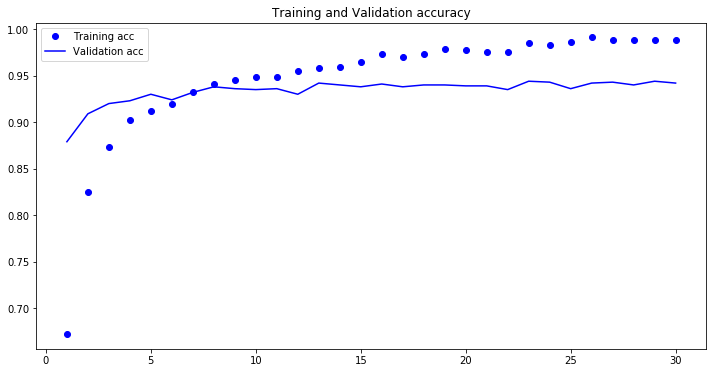

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

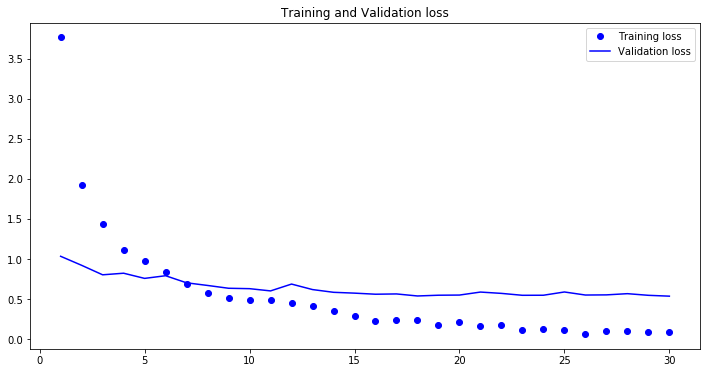

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

验证精度达到了约90%，虽然 Dropout 比率相当大，但还是存在过拟合。这是因为没有使用数据增强，而数据增强对防止小型图像数据集的过拟合非常重要。

### 使用数据增强的特征提取（需要gpu）

特征提取的第二种方法，速度更慢，计算代价更高，但是在训练期间可以是同数据增强。

这种方法就是：扩展 conv_base 模型，然后在输入数据上端到端地运行模型。

模型的行为和层类似，所以可以向 Sequential 模型中添加一个模型（如 conv_base），就像添加一个层一样。

#### 在卷积集上添加一个密集连接分类器

In [11]:
from keras import models
from keras import layers

In [12]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

现在的模型架构如下：

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


VGG16 的卷积基有 14714688 个参数，非常多，又要在其上添加的分类器有 200 万个，所以仅仅使用 CPU 很难完成训练。

在编译和训练模型之前，一定要“冻结”卷积基，冻结一个或多个层是指在训练过程中保持其权重不变。

因为 VGG16 其上添加的 Dense 层是随机初始化的，所以非常大的权重更新会在网络中传播，对之前 VGG16 学到的表示造成很大破坏。

在 Keras 中，冻结网络的方法是将其 trainable 属性设为 False 。

In [14]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [15]:
conv_base.trainable = False

In [16]:
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


如此设置之后，只有添加了两个 Dense 层的权重才会被训练。总共有4个权重张量，每层2个。

注意，为了让这些修改生效，必须先编译模型，如果在编译之后修改了权重的 trainable 属性，那么应该重新编译模型，否则这些修改将被忽略。

现在开始训练，使用和前一个例子相同的数据增强设置。

#### 利用冻结的卷积基端到端地训练模型

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=80,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/80
100/100 [==============================] - 33s 331ms/step - loss: 0.6303 - acc: 0.6585 - val_loss: 0.5288 - val_acc: 0.7790
Epoch 2/80
100/100 [==============================] - 33s 334ms/step - loss: 0.5435 - acc: 0.7535 - val_loss: 0.4481 - val_acc: 0.8310
Epoch 3/80
100/100 [==============================] - 33s 327ms/step - loss: 0.4869 - acc: 0.7805 - val_loss: 0.4098 - val_acc: 0.8270
Epoch 4/80
100/100 [==============================] - 33s 329ms/step - loss: 0.4589 - acc: 0.7980 - val_loss: 0.3701 - val_acc: 0.8490
Epoch 5/80
100/100 [==============================] - 33s 330ms/step - loss: 0.4331 - acc: 0.8205 - val_loss: 0.3434 - val_acc: 0.8600
Epoch 6/80
100/100 [==============================] - 33s 329ms/step - loss: 0.4048 - acc: 0.8255 - val_loss: 0.3291 - val_acc: 0.8640
Epoch 7/80
100/100 [==============================] - 33s 329ms/step - loss: 0.4046 - acc: 0.8255 - val_lo

Epoch 61/80
100/100 [==============================] - 32s 324ms/step - loss: 0.2669 - acc: 0.8855 - val_loss: 0.2368 - val_acc: 0.9020
Epoch 62/80
100/100 [==============================] - 32s 324ms/step - loss: 0.2773 - acc: 0.8800 - val_loss: 0.2373 - val_acc: 0.9010
Epoch 63/80
100/100 [==============================] - 32s 324ms/step - loss: 0.2690 - acc: 0.8900 - val_loss: 0.2369 - val_acc: 0.9060
Epoch 64/80
100/100 [==============================] - 32s 324ms/step - loss: 0.2675 - acc: 0.8865 - val_loss: 0.2363 - val_acc: 0.9060
Epoch 65/80
100/100 [==============================] - 32s 324ms/step - loss: 0.2844 - acc: 0.8785 - val_loss: 0.2346 - val_acc: 0.9040
Epoch 66/80
100/100 [==============================] - 32s 324ms/step - loss: 0.2716 - acc: 0.8745 - val_loss: 0.2402 - val_acc: 0.9000
Epoch 67/80
100/100 [==============================] - 32s 324ms/step - loss: 0.2485 - acc: 0.8970 - val_loss: 0.2355 - val_acc: 0.9070
Epoch 68/80
100/100 [===========================

#### 绘制结果

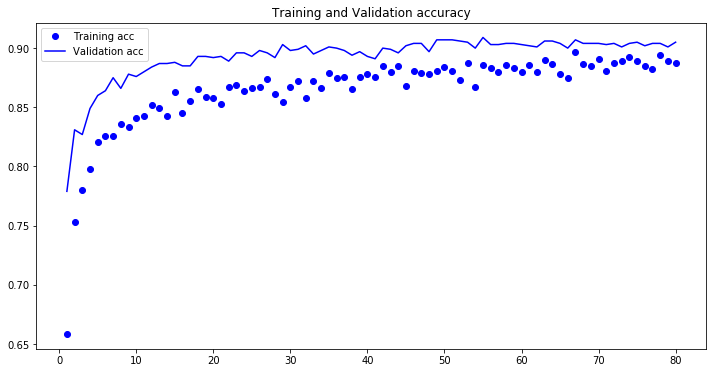

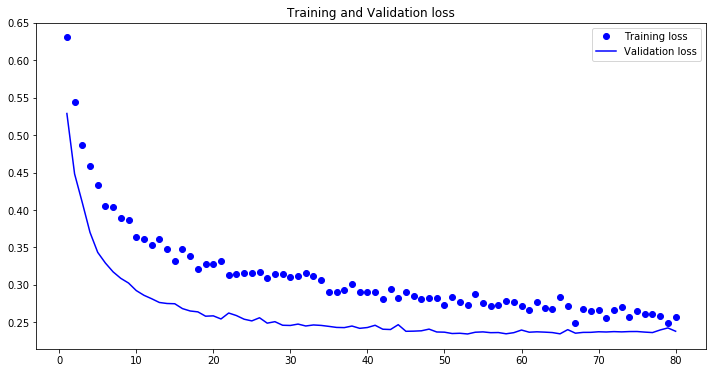

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

验证精度明显提升。

## 微调模型

另一种广泛使用的模型复用的方法是模型微调，与特征提取互为补充。

微调是指将模型基顶部的几层冻结，并将这解冻的几层与新增加的部分联合训练。

之所以叫作微调，是因为它只是略微调整了所复用模型中更加抽象的表示，以便让这些表示与手头的问题更加相关。

冻结是为了能够在卷积基上训练随机初始化的分类器。同理，只有上面的分类器训练好了，才能微调卷积基的顶部几层。

如果分类器没有训练好，那么训练期间通过网络传播的误差信号会特别大，微调的几层之前学到的表示都会被破坏。步骤如下：

（1）在已经训练好的基网络上添加自定义网络

（2）冻结基网络

（3）训练所添加的部分

（4）解冻基网络的一些层

（5）联合训练解冻的这些层和添加的部分

之前已经完成了前3个步骤，继续第四步：先解冻 conv_base ，然后冻结其中的部分层。

卷积基架构如下：

In [20]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

![vgg16_modified](img/vgg16_modified.png)

微调最后三个卷积层，直到 block4_pool 的所有层都应该被冻结，而 block5_conv1 、 block5_conv2 、 block_conv3 三层应该是可训练的。

为什么不微调更多层？为什么不微调整个卷积基？可以这么做，但需要考虑以下几点：

（1）卷积基中更靠底部的层编码的是更加通用的可复用特征，而更靠顶部的层编码的是更专业化的特征。微调这些更专业化的特征更加有用，因为它们需要在新问题上改变用途。微调更靠底部的层，得到的回报会更少。

（2）训练的参数越多，过拟合的风险越大。卷积基有 1500 万个参数，所以在你的小型数据集上训练这么多参数是有风险的。

因此，在这种情况下，一个好策略是仅仅微调卷积基的最后三层。

### 冻结直到某一层的所有层

In [21]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### 微调模型

现在开始微调网络，使用学习率非常小的 RMSProp 优化器来实现。

之所以使用小学习率，是为了对于微调的三层表示，变化范围不要太大，太大的权重更新可能会破坏这些表示。

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc']
             )

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=120,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/120
100/100 [==============================] - 33s 328ms/step - loss: 0.2631 - acc: 0.8810 - val_loss: 0.2331 - val_acc: 0.9080
Epoch 2/120
100/100 [==============================] - 32s 324ms/step - loss: 0.2683 - acc: 0.8860 - val_loss: 0.2446 - val_acc: 0.8960
Epoch 3/120
100/100 [==============================] - 32s 324ms/step - loss: 0.2697 - acc: 0.8860 - val_loss: 0.2400 - val_acc: 0.8970
Epoch 4/120
100/100 [==============================] - 32s 324ms/step - loss: 0.2452 - acc: 0.8985 - val_loss: 0.2417 - val_acc: 0.8970
Epoch 5/120
100/100 [==============================] - 32s 324ms/step - loss: 0.2700 - acc: 0.8855 - val_loss: 0.2472 - val_acc: 0.8950
Epoch 6/120
100/100 [==============================] - 32s 324ms/step - loss: 0.2419 - acc: 0.8980 - val_loss: 0.2452 - val_acc: 0.8940
Epoch 7/120
100/100 [==============================] - 32s 324ms/step - loss: 0.2690 - acc: 0.8815 - val_loss: 0.2390 - val_acc: 0.9030
Epoch 8/120
100/100 [===========================

Epoch 61/120
100/100 [==============================] - 32s 324ms/step - loss: 0.2452 - acc: 0.8985 - val_loss: 0.2451 - val_acc: 0.8980
Epoch 62/120
100/100 [==============================] - 32s 324ms/step - loss: 0.2283 - acc: 0.9035 - val_loss: 0.2400 - val_acc: 0.9090
Epoch 63/120
100/100 [==============================] - 32s 324ms/step - loss: 0.2558 - acc: 0.8885 - val_loss: 0.2521 - val_acc: 0.8960
Epoch 64/120
100/100 [==============================] - 32s 324ms/step - loss: 0.2442 - acc: 0.8900 - val_loss: 0.2448 - val_acc: 0.9060
Epoch 65/120
100/100 [==============================] - 32s 324ms/step - loss: 0.2262 - acc: 0.9060 - val_loss: 0.2265 - val_acc: 0.9100
Epoch 66/120
100/100 [==============================] - 32s 324ms/step - loss: 0.2368 - acc: 0.9000 - val_loss: 0.2451 - val_acc: 0.9040
Epoch 67/120
100/100 [==============================] - 32s 324ms/step - loss: 0.2447 - acc: 0.8965 - val_loss: 0.2587 - val_acc: 0.8980
Epoch 68/120
100/100 [===================

100/100 [==============================] - 32s 324ms/step - loss: 0.2217 - acc: 0.9090 - val_loss: 0.2489 - val_acc: 0.8990


绘图查看结果：

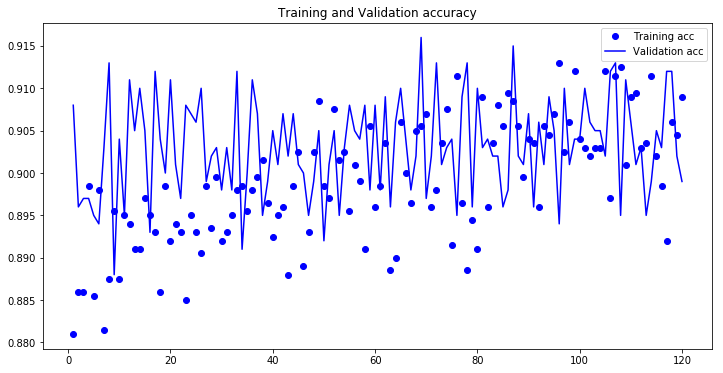

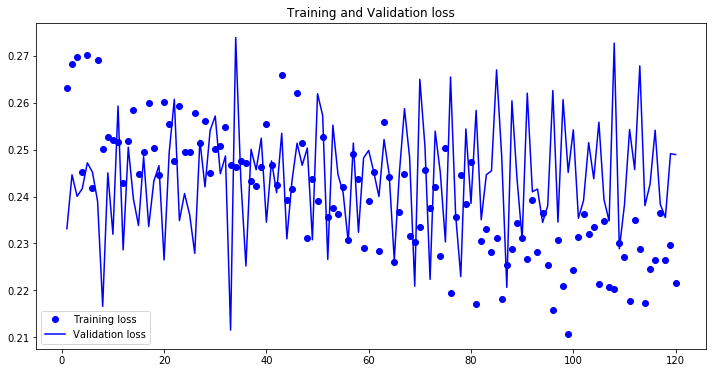

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

这些曲线看起来包含噪声，为了让图像更具可读性，将每个损失和精度都替换为指数移动平均值，从而让曲线变得平滑。

### 使曲线变得平滑

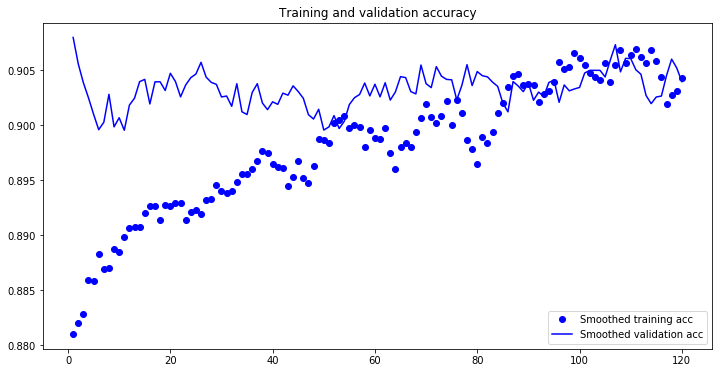

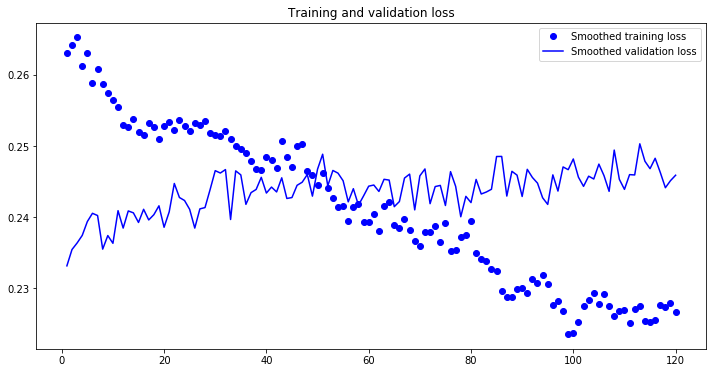

In [24]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.figure(figsize=(12, 6))

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12, 6))

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

在测试数据上最终评估这个模型

In [25]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test_acc:',test_acc)

Found 1000 images belonging to 2 classes.
test_acc: 0.9029999935626983
